# M 7.0 - Haiti region
#### 2010-01-12 21:53:10 (UTC)18.443°N 72.571°W13.0 km depth
###### https://earthquake.usgs.gov/earthquakes/eventpage/usp000h60h/executive

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statistics 
import seaborn as sns # for plot visualization
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas_datareader.data as web
import datetime
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset = pd.read_csv('sample_data/haiti.csv')
dataset_error_index = dataset
dataset.tail(2)

FileNotFoundError: ignored

In [ ]:
dataset['new_date'] = dataset['date'].str.cat(dataset['time'], sep =" ") 
dataset['new_date'] = pd.to_datetime(dataset['new_date'],format="%d-%b-%Y %H:%M:%S") #convert from string to datetime
dataset= dataset[['new_date','tec']]
dataset.head(2)

,new_date,tec
0,2009-11-15 00:00:00,8.450762
1,2009-11-15 02:00:00,8.756442


In [ ]:
train_df = dataset.loc[(dataset["new_date"] <= "2010-01-04 00:00:00")]
test_df = dataset.loc[(dataset["new_date"] > "2010-01-03 00:00:00") & (dataset["new_date"] <= "2010-01-16 00:00:00")]
train_df.head(2)

,new_date,tec
0,2009-11-15 00:00:00,8.450762
1,2009-11-15 02:00:00,8.756442


In [ ]:
test_df.tail(2)

,new_date,tec
743,2010-01-15 22:00:00,11.093591
744,2010-01-16 00:00:00,7.434167


In [ ]:
train_data = train_df.loc[:,'tec'].to_numpy()
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(601,)


In [ ]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 12
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(589, 12, 1)
X_train:
[[ 8.4507625 ]
 [ 8.7564425 ]
 [ 7.8341825 ]
 [ 6.59306687]
 [ 6.27081562]
 [ 6.32279125]
 [10.23952875]
 [13.21316875]
 [14.07652   ]
 [16.09714438]
 [17.23024   ]
 [12.70906   ]]


y_train: [[7.90446687]]



In [ ]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 48, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 48))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 50, batch_size = 12, validation_split=.30)

Epoch 1/50
35/35 [==============================] - 1s 33ms/step - loss: 0.0759 - val_loss: 0.0432
Epoch 2/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0580 - val_loss: 0.0376
Epoch 3/50
35/35 [==============================] - 0s 12ms/step - loss: 0.0489 - val_loss: 0.0329
Epoch 4/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0281 - val_loss: 0.0202
Epoch 5/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0174 - val_loss: 0.0279
Epoch 6/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0159 - val_loss: 0.0104
Epoch 7/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 8/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0126 - val_loss: 0.0072
Epoch 9/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0110 - val_loss: 0.0075
Epoch 10/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0124 - val_loss: 0.0085
Epoch 11/

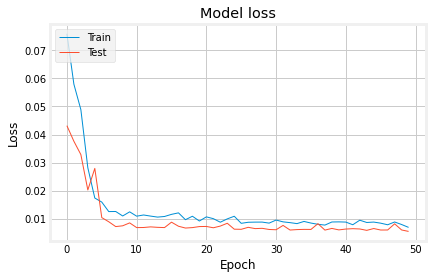

In [ ]:
# Plot training & validation loss values
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(history.history['loss'], linewidth=1.0)
plt.plot(history.history['val_loss'], linewidth=1.0)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
results = model.evaluate(X_train, y_train)
print("test loss", results)

19/19 [==============================] - 0s 4ms/step - loss: 0.0056
test loss 0.005569768138229847


In [ ]:
test_data = test_df['tec'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 12
X_test, y_test = create_dataset(test_data, time_steps)
# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

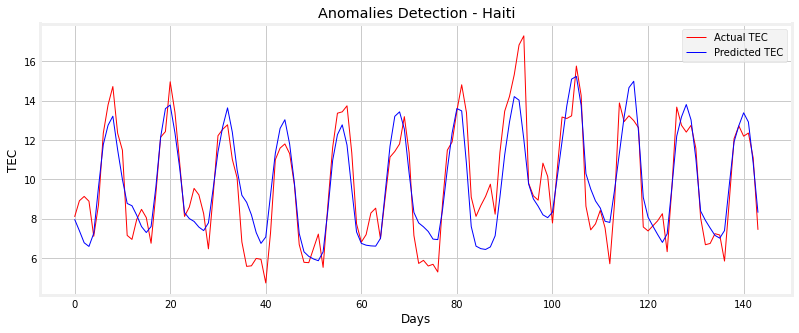

In [ ]:
# plot the results 
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
plt.plot(org_y, color = 'red', label = 'Actual TEC', linewidth=1.0)
plt.plot(predicted_y, color = 'blue', label = 'Predicted TEC', linewidth=1.0)
#plt.axvline(x=10, color='black', linestyle='-', linewidth=1.0)
#plt.axvline(x="2010-04-10 00:00:00", color='black', linestyle='-', linewidth=1.0)
#plt.axvline(x="2010-01-12 22:00:00", color='black', linestyle='-', linewidth=1.0)
plt.title('Anomalies Detection - Haiti')
plt.xlabel('Days')
plt.ylabel('TEC')
plt.legend()
plt.show()

In [ ]:
error_data = org_y - predicted_y

In [ ]:
len(error_data)

144

In [ ]:
dataset_error_index['date'] = pd.to_datetime(dataset_error_index['date'],format="%d-%b-%Y") #convert from string to datetime
error_dataset = dataset_error_index.loc[(dataset_error_index["date"] > "2010-01-03") & (dataset_error_index["date"] < "2010-01-16")]
#error_dataset = error_dataset[:-1]
error_dataset['error'] = error_data
error_dataset['predicted'] = predicted_y
#len(error_dataset)
error_dataset.head(2)

,date,time,tec,new_date,error,predicted
600,2010-01-04,00:00:00,7.163351,2010-01-04 00:00:00,0.121420,7.970560
601,2010-01-04,02:00:00,8.091980,2010-01-04 02:00:00,1.524103,7.387272


In [ ]:
error_dataset['date'] = error_dataset['date'].dt.strftime('%Y-%m-%d')
error_dataset = error_dataset.set_index(['new_date'])
error_dataset.head(2)

,date,time,tec,error,predicted
new_date,,,,,
2010-01-04 00:00:00,2010-01-04,00:00:00,7.163351,0.121420,7.970560
2010-01-04 02:00:00,2010-01-04,02:00:00,8.091980,1.524103,7.387272


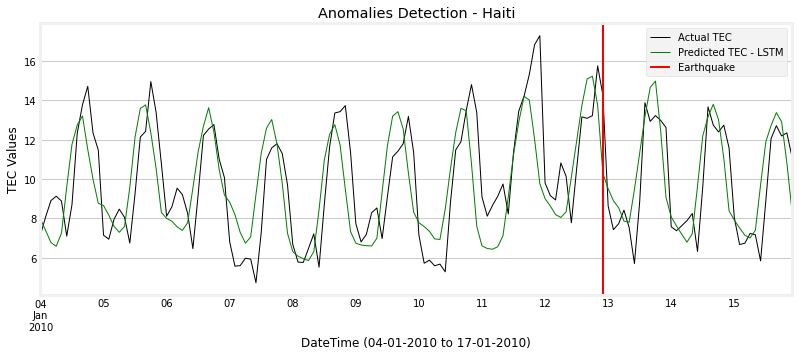

In [ ]:
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
error_dataset["tec"].plot(subplots=True, color='black', linewidth=1.0, label = "Actual TEC")
error_dataset["predicted"].plot(subplots=True, color='green', linewidth=1.0, label = "Predicted TEC - LSTM")
plt.axvline(x="2010-01-12 22:00:00", color='red', linestyle='-', linewidth=2.0, label = "Earthquake")
#plt.axvline(x="2015-04-10 00:00:00", color='black', linestyle='-', linewidth=1.0)
#plt.axvline(x="2015-04-21 00:00:00", color='black', linestyle='-', linewidth=1.0)
plt.title('Anomalies Detection - Haiti')
plt.xlabel('DateTime (04-01-2010 to 17-01-2010)')
plt.ylabel('TEC Values')
plt.legend()
plt.show()

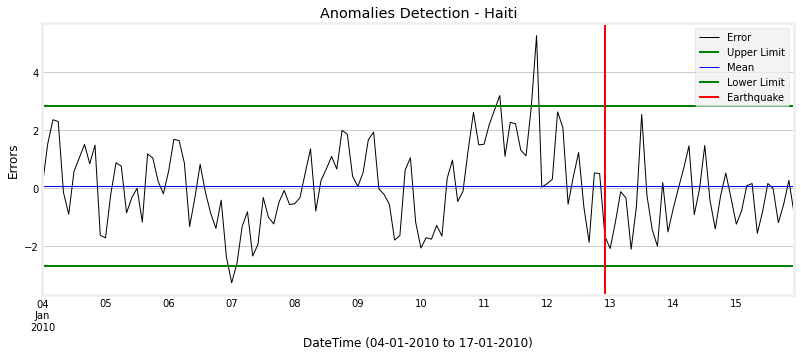

In [ ]:
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
error_dataset["error"].plot(subplots=True, color='black', linewidth=1.0, label = "Error")
plt.axhline(y=np.mean(error_dataset['error']) + (2*np.std(error_dataset['error'])), color='green', linestyle='-', linewidth=2.0, label = "Upper Limit")
plt.axhline(y=np.mean(error_dataset['error']), color='blue', linestyle='-', linewidth=1.0, label = "Mean")
plt.axhline(y=np.mean(error_dataset['error']) + (-2*np.std(error_dataset['error'])), color='green', linestyle='-', linewidth=2.0, label = "Lower Limit")
plt.axvline(x="2010-01-12 22:00:00", color='red', linestyle='-', linewidth=2.0, label = "Earthquake")
#plt.axvline(x="2015-04-10 00:00:00", color='black', linestyle='-', linewidth=1.0)
#plt.axvline(x="2015-04-21 00:00:00", color='black', linestyle='-', linewidth=1.0)
plt.title('Anomalies Detection - Haiti')
plt.xlabel('DateTime (04-01-2010 to 17-01-2010)')
plt.ylabel('Errors')
plt.legend()
plt.show()

# ARIMA

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statistics 
import seaborn as sns # for plot visualization
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
ARIMA_dataset = pd.read_csv('sample_data/train.csv')
ARIMA_dataset.head(2)

,date,time,tec
0,15-Nov-09,00:00:00,8.450762
1,15-Nov-09,02:00:00,8.756442


In [ ]:
ARIMA_dataset['new_date'] = ARIMA_dataset['date'].str.cat(ARIMA_dataset['time'], sep =" ") 
ARIMA_dataset['new_date'] = pd.to_datetime(ARIMA_dataset['new_date'],format="%d-%b-%y %H:%M:%S") #convert from string to datetime
ARIMA_dataset= ARIMA_dataset[['new_date','tec']]
ARIMA_indexedDataset = ARIMA_dataset.set_index(['new_date'])
ARIMA_indexedDataset.head(2)

,tec
new_date,
2009-11-15 00:00:00,8.450762
2009-11-15 02:00:00,8.756442


In [ ]:
ARIMA_indexedDataset.index = pd.to_datetime(ARIMA_indexedDataset.index)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa167ad908>],
      dtype=object)

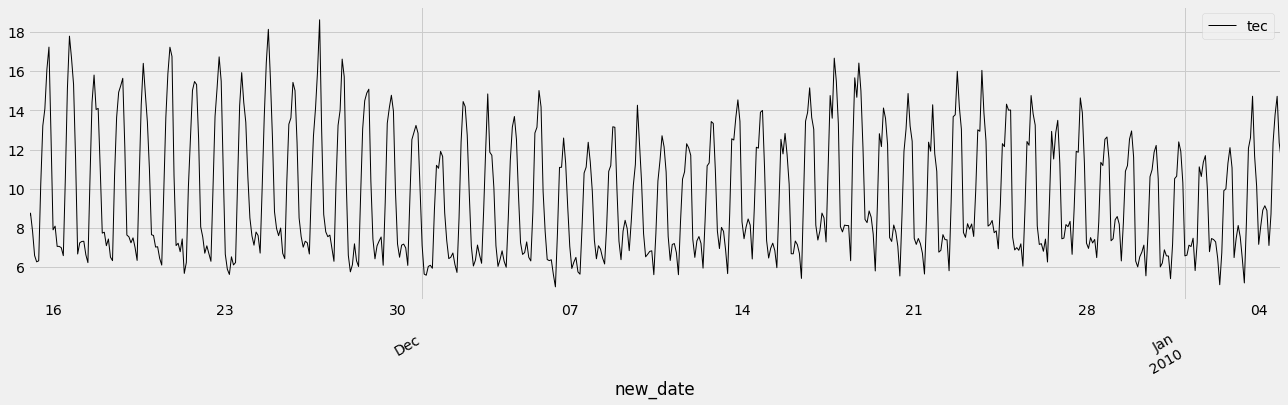

In [ ]:
ARIMA_indexedDataset.plot(subplots=True, figsize=(20,6),color='black', linewidth=1.0)

In [ ]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(20,6))

    plt.plot(ts, label='Actual Mean',color='black',linewidth=1.5)
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean TEC")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [ ]:
# Augmented Dickey–Fuller test
def test_stationarity(timeseries):    
    timeseries.dropna(inplace=True)
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['tec'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
ARIMA_train_df = ARIMA_indexedDataset

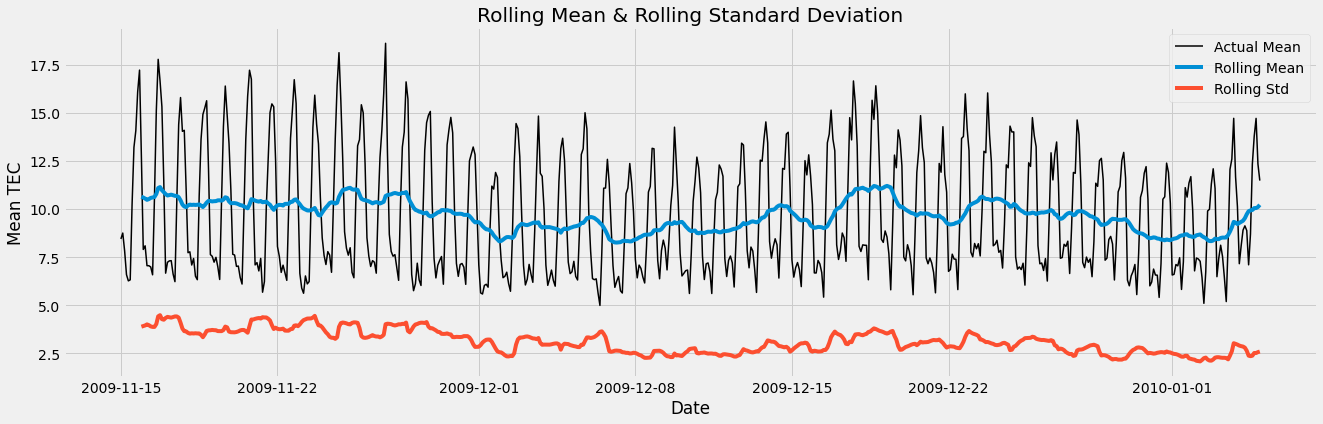

Results of Dickey Fuller Test:
Test Statistic                  -3.863629
p-value                          0.002319
#Lags Used                      19.000000
Number of Observations Used    592.000000
Critical Value (1%)             -3.441444
Critical Value (5%)             -2.866435
Critical Value (10%)            -2.569377
dtype: float64


In [ ]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(ARIMA_train_df.tec)
test_stationarity(ARIMA_train_df)

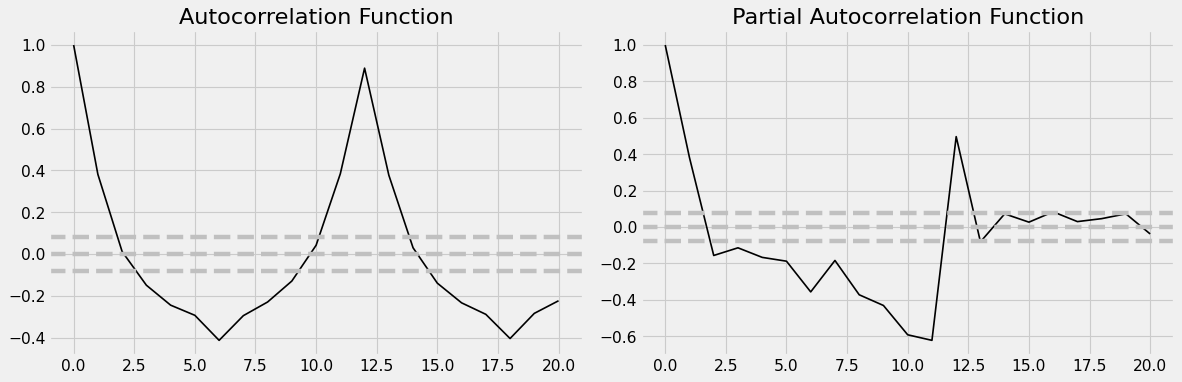

In [ ]:
acf_lag = acf(ARIMA_train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(ARIMA_train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(acf_lag, linewidth=1.5,color='black')
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(ARIMA_train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(ARIMA_train_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag, linewidth=1.5,color='black')
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(ARIMA_train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(ARIMA_train_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In [ ]:
model = ARIMA(ARIMA_train_df.values, order=(3,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  612
Model:                     ARMA(3, 3)   Log Likelihood               -1021.590
Method:                       css-mle   S.D. of innovations              1.276
Date:                Sun, 16 Aug 2020   AIC                           2059.180
Time:                        09:31:19   BIC                           2094.514
Sample:                             0   HQIC                          2072.923
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6812      0.088    110.460      0.000       9.509       9.853
ar.L1.y        1.8841      0.001   1486.255      0.000       1.882       1.887
ar.L2.y       -1.2628      0.002   -618.702      0.0

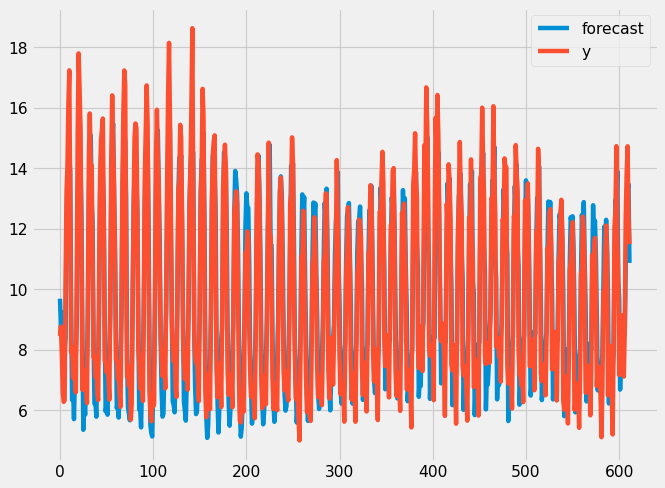

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [ ]:
#train_df2 = train_df.iloc[1:]
ARIMA_train_error_data = ARIMA_train_df.tec - model_fit.predict()
ARIMA_train_error_data.head()

new_date
2009-11-15 00:00:00   -1.230407
2009-11-15 02:00:00    0.038416
2009-11-15 04:00:00   -1.399146
2009-11-15 06:00:00   -1.612622
2009-11-15 08:00:00   -1.343016
Name: tec, dtype: float64

In [ ]:
ARIMA_test_dataset = pd.read_csv('sample_data/test.csv')
ARIMA_test_dataset['new_date'] = ARIMA_test_dataset['date'].str.cat(ARIMA_test_dataset['time'], sep =" ") 
ARIMA_test_dataset['new_date'] = pd.to_datetime(ARIMA_test_dataset['new_date'],format="%d-%b-%y %H:%M:%S") #convert from string to datetime
ARIMA_test_dataset= ARIMA_test_dataset[['new_date','tec']]
ARIMA_test_indexedDataset = ARIMA_test_dataset.set_index(['new_date'])
ARIMA_test_indexedDataset.head(2)

,tec
new_date,
2010-01-05 00:00:00,7.150207
2010-01-05 02:00:00,6.947327


In [ ]:
ARIMA_test_df = ARIMA_test_indexedDataset

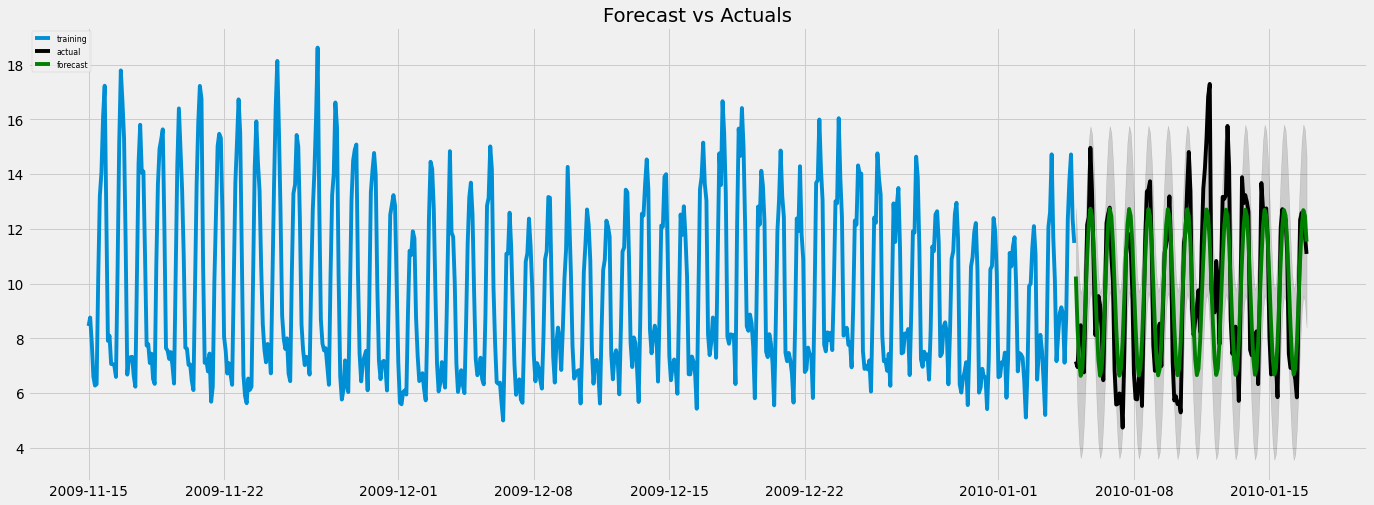

In [ ]:
fc, se, conf = model_fit.forecast(len(ARIMA_test_df), alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
ARIMA_fc_series = pd.Series(fc, index=ARIMA_test_df.index)
lower_series = pd.Series(conf[:, 0], index=ARIMA_test_df.index)
upper_series = pd.Series(conf[:, 1], index=ARIMA_test_df.index)

# # Plot
plt.figure(figsize=(22,8), dpi=70)
plt.plot(ARIMA_train_df, label='training')
plt.plot(ARIMA_test_df, label='actual',color='black')
plt.plot(ARIMA_fc_series, label='forecast', color='green')
#plt.axvline(x="2010-01-13 10:00:00", color='red', linestyle='-', linewidth=4, label='Day and Time of Earthquake : 2011-10-23 10:41:23')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()
# test_df.index

In [ ]:
ARIMA_error_data = ARIMA_test_df.tec-ARIMA_fc_series
ARIMA_error_data.head(2)

new_date
2010-01-05 00:00:00   -3.107118
2010-01-05 02:00:00   -1.485185
dtype: float64

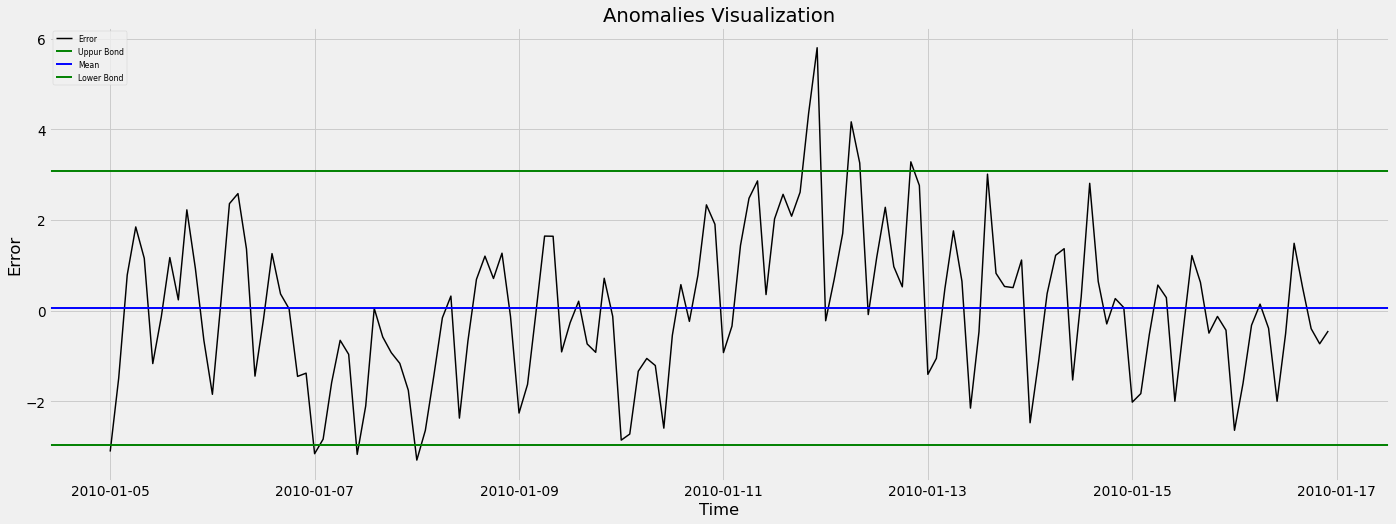

In [ ]:
plt.figure(figsize=(22,8), dpi=70)
plt.plot(ARIMA_error_data, label='Error', color='black', linewidth=1.5)
plt.axhline(y=statistics.mean(ARIMA_error_data) + 1.8*statistics.stdev(ARIMA_error_data), color='green', linestyle='-', linewidth=2, label='Uppur Bond')
plt.axhline(y=statistics.mean(ARIMA_error_data), color='blue', linestyle='-', linewidth=2, label='Mean')
plt.axhline(y=statistics.mean(ARIMA_error_data) - (1.8*statistics.stdev(ARIMA_error_data)), color='green', linestyle='-', linewidth=2, label='Lower Bond')
#plt.axvline(x="2010-01-13 00:00:00", color='red', linestyle='-', linewidth=4, label='Day and Time of Earthquake : 2011-10-23 10:41:23')
plt.xlabel('Time') 
plt.ylabel('Error') 
plt.title('Anomalies Visualization')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
error_dataset['error_ARIMA'] = ARIMA_error_data
error_dataset['predicted_ARIMA'] = ARIMA_fc_series
error_dataset.tail(2)

,date,time,tec,error,predicted,error_ARIMA,predicted_ARIMA
new_date,,,,,,,
2010-01-15 20:00:00,2010-01-15,20:00:00,12.354816,0.266725,10.826866,-0.125481,12.480296
2010-01-15 22:00:00,2010-01-15,22:00:00,11.093591,-0.874174,8.308341,-0.429083,11.522674


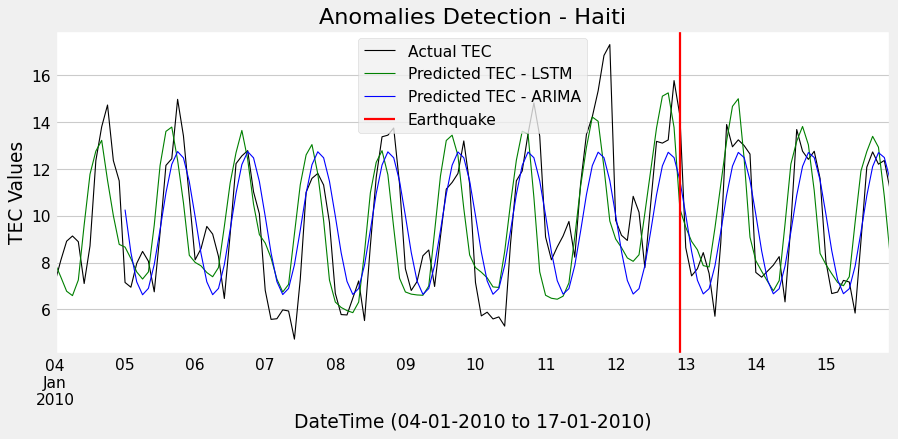

In [ ]:
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
error_dataset["tec"].plot(subplots=True, color='black', linewidth=1.0, label = "Actual TEC")
error_dataset["predicted"].plot(subplots=True, color='green', linewidth=1.0, label = "Predicted TEC - LSTM")
error_dataset["predicted_ARIMA"].plot(subplots=True, color='blue', linewidth=1.0, label = "Predicted TEC - ARIMA")
plt.axvline(x="2010-01-12 22:00:00", color='red', linestyle='-', linewidth=2.0, label = "Earthquake")
#plt.axvline(x="2015-04-10 00:00:00", color='black', linestyle='-', linewidth=1.0)
#plt.axvline(x="2015-04-21 00:00:00", color='black', linestyle='-', linewidth=1.0)
plt.title('Anomalies Detection - Haiti')
plt.xlabel('DateTime (04-01-2010 to 17-01-2010)')
plt.ylabel('TEC Values')
plt.legend()
plt.show()

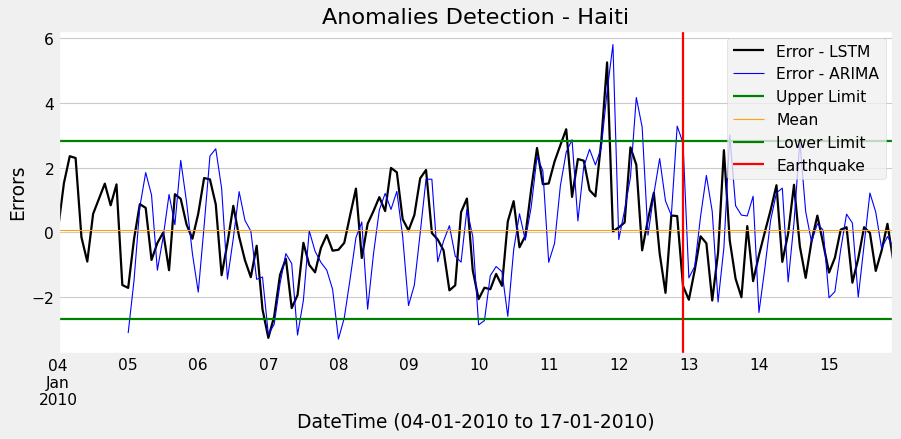

In [ ]:
plt.figure(figsize=(12,5))
ax = plt.gca()
ax.set_facecolor('white')
error_dataset["error"].plot(subplots=True, color='black', linewidth=2.0, label = "Error - LSTM")
error_dataset["error_ARIMA"].plot(subplots=True, color='blue', linewidth=1.0, label = "Error - ARIMA")
plt.axhline(y=np.mean(error_dataset['error']) + (2*np.std(error_dataset['error'])), color='green', linestyle='-', linewidth=2.0, label = "Upper Limit")
plt.axhline(y=np.mean(error_dataset['error']), color='ORANGE', linestyle='-', linewidth=1.0, label = "Mean")
plt.axhline(y=np.mean(error_dataset['error']) + (-2*np.std(error_dataset['error'])), color='green', linestyle='-', linewidth=2.0, label = "Lower Limit")
plt.axvline(x="2010-01-12 22:00:00", color='red', linestyle='-', linewidth=2.0, label = "Earthquake")
#plt.axvline(x="2015-04-10 00:00:00", color='black', linestyle='-', linewidth=1.0)
#plt.axvline(x="2015-04-21 00:00:00", color='black', linestyle='-', linewidth=1.0)
plt.title('Anomalies Detection - Haiti')
plt.xlabel('DateTime (04-01-2010 to 17-01-2010)')
plt.ylabel('Errors')
plt.legend()
plt.show()